In [2]:
#Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



**Data collection and manipulation**

In [3]:
def assign_segment(hour):
    if 0 <= hour < 3:
        return 1
    elif 3 <= hour < 6:
        return 2
    elif 6 <= hour < 9:
        return 3
    elif 9 <= hour < 12:
        return 4
    elif 12 <= hour < 15:
        return 5
    elif 15 <= hour < 18:
        return 6
    elif 18 <= hour < 21:
        return 7
    else:
        return 8

#MSP data
df_MSP = pd.read_csv('MSP.csv')
df_MSP.rename(columns={'Temperature(°C)': 'Temperature', 'Barometric pressure(hPa)': 'Pressure', 'Humidity(%)': 'Humidity', 'Feels like Temperature(°C)': 'Apparent temperature'}, inplace=True)  
filtered_MSP = df_MSP[['time', 'Temperature', 'Pressure', 'Humidity', 'Apparent temperature']]
filtered_MSP['time'] = pd.to_datetime(filtered_MSP['time'], errors='coerce', dayfirst=True)
filtered_MSP['hour segment'] = filtered_MSP['time'].dt.hour.apply(assign_segment)

#Meteostat, free
df_meteostat = pd.read_csv('Meteostat.csv')
df_meteostat.rename(columns={'temp': 'Temperature', 'prcp': 'Precipitation', 'pres': 'Pressure', 'rhum': 'Humidity'}, inplace=True)
filter_meteostat = df_meteostat[['time', 'Temperature', 'Pressure', 'Humidity']]
filter_meteostat['time'] = pd.to_datetime(filter_meteostat['time'], errors='coerce', dayfirst=True)
filter_meteostat['hour segment'] = filter_meteostat['time'].dt.hour.apply(assign_segment)

#Open Meteo, free
df_openmeteo = pd.read_csv('Open_meteo.csv')
df_openmeteo.rename(columns={'temperature_2m': 'Temperature', 'pressure_msl (hPa)': 'Pressure', 'relative_humidity_2m (%)': 'Humidity', 'apparent_temperature': 'Apparent temperature'}, inplace=True)
filter_openmeteo = df_openmeteo[['time', 'Temperature', 'Pressure', 'Humidity', 'Apparent temperature']]
filter_openmeteo['time'] = pd.to_datetime(filter_openmeteo['time'], errors='coerce')
filter_openmeteo['hour segment'] = filter_openmeteo['time'].dt.hour.apply(assign_segment)

#Visual Crossing, free
df_visualcrossing = pd.read_csv('Visual_crossing.csv')
df_visualcrossing.rename(columns={'datetime': 'time', 'temp': 'Temperature', 'sealevelpressure': 'Pressure', 'humidity': 'Humidity', 'feelslike': 'Apparent temperature'}, inplace=True)
filter_visualcrossing = df_visualcrossing[['time', 'Temperature', 'Pressure', 'Humidity', 'Apparent temperature']]
filter_visualcrossing['time'] = pd.to_datetime(filter_visualcrossing['time'], errors='coerce')
filter_visualcrossing['hour segment'] = filter_visualcrossing['time'].dt.hour.apply(assign_segment)

#Weather API, paid
df_weatherapi = pd.read_csv('WeatherAPI.csv')
df_weatherapi.rename(columns={'Temperature (C)': 'Temperature', 'pressure_mb': 'Pressure', 'Humidity (%)': 'Humidity', 'feelslike_c': 'Apparent temperature'}, inplace=True)
filter_weatherapi = df_weatherapi[['time', 'Temperature', 'Pressure', 'Humidity', 'Apparent temperature']]
filter_weatherapi['time'] = pd.to_datetime(filter_weatherapi['time'], errors='coerce', dayfirst=True)
filter_weatherapi['hour segment'] = filter_weatherapi['time'].dt.hour.apply(assign_segment)

#World Weather Online, paid
df_worldweatheronline = pd.read_csv('World_weather_online.csv')
df_worldweatheronline.rename(columns={'Temperature (C)': 'Temperature', 'Pressure (hPa)': 'Pressure', 'Timestamp': 'time', 'Humidity (%)': 'Humidity', 'FeelsLikeC': 'Apparent temperature'}, inplace=True)
filter_worldweatheronline = df_worldweatheronline[['time', 'Temperature', 'Pressure', 'Humidity', 'Apparent temperature']]
filter_worldweatheronline['time'] = pd.to_datetime(filter_worldweatheronline['time'], errors='coerce', dayfirst=True)
filter_worldweatheronline['hour segment'] = filter_worldweatheronline['time'].dt.hour.apply(assign_segment)


filter_meteostat = filter_meteostat.dropna(subset=['time'])
filter_openmeteo = filter_openmeteo.dropna(subset=['time'])
filter_visualcrossing = filter_visualcrossing.dropna(subset=['time'])
filter_weatherapi = filter_weatherapi.dropna(subset=['time'])
filter_worldweatheronline = filter_worldweatheronline.dropna(subset=['time'])
filtered_MSP = filtered_MSP.dropna(subset=['time'])


C:\Users\jelle\AppData\Local\Temp\ipykernel_39516\1439768285.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_MSP['time'] = pd.to_datetime(filtered_MSP['time'], errors='coerce', dayfirst=True)
C:\Users\jelle\AppData\Local\Temp\ipykernel_39516\1439768285.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_MSP['hour segment'] = filtered_MSP['time'].dt.hour.apply(assign_segment)
C:\Users\jelle\AppData\Local\Temp\ipykernel_39516\1439768285.py:30: SettingWithCopyWarning: 
A value is trying

In [4]:
#cleaning data for statistical analysis
def drop_na(source_name, data):
   
    cleaned_temperature = data.dropna(subset=[f'Temperature_MSP', f'Temperature_{source_name}'])
    cleaned_pressure = data.dropna(subset=[f'Pressure_MSP', f'Pressure_{source_name}'])
    cleaned_humidity = data.dropna(subset=[f'Humidity_MSP', f'Humidity_{source_name}'])
    return {
        "Temperature": cleaned_temperature,
        "Pressure": cleaned_pressure,
        "Humidity": cleaned_humidity
    }
data_sources = [
    ("Meteostat", filter_meteostat),
    ("Open Meteo", filter_openmeteo),
    ("Visual Crossing", filter_visualcrossing),
    ("Weather API", filter_weatherapi),
    ("World Weather Online", filter_worldweatheronline),
]
merged_data = {"MSP": filtered_MSP}
for name, df in data_sources:
   merged_data[name] = pd.merge(filtered_MSP, df, on='time', suffixes=('_MSP', f'_{name}'))
cleaned_merged_data = {}
for name, data in merged_data.items():
    if name == "MSP":
        cleaned_merged_data[name] = {"Temperature": data, "Pressure": data, "Humidity": data}
    else:
        cleaned_merged_data[name] = drop_na(name, data)


**Plotting (functions)**

In [6]:
#Weekly
def plot_comparison(weather_variable):
 # Filter data to include only up to '17-01-2025'
    end_date = '2025-01-17'
    filter_meteostat_filtered = filter_meteostat[filter_meteostat['time'] <= end_date]
    filter_openmeteo_filtered = filter_openmeteo[filter_openmeteo['time'] <= end_date]
    filter_visualcrossing_filtered = filter_visualcrossing[filter_visualcrossing['time'] <= end_date]
    filter_weatherapi_filtered = filter_weatherapi[filter_weatherapi['time'] <= end_date]
    filter_worldweatheronline_filtered = filter_worldweatheronline[filter_worldweatheronline['time'] <= end_date]
    filtered_MSP_filtered = filtered_MSP[filtered_MSP['time'] <= end_date]

   
    plt.figure(figsize=(20, 6))
    plt.plot(filter_meteostat_filtered['time'], filter_meteostat_filtered[weather_variable], label='Meteostat (free)', marker='v', markersize=3, alpha=0.5)
    plt.plot(filter_openmeteo_filtered['time'], filter_openmeteo_filtered[weather_variable], label='Open Meteo (free)', marker='v', markersize=3, alpha=0.5)
    plt.plot(filter_visualcrossing_filtered['time'], filter_visualcrossing_filtered[weather_variable], label='Visual Crossing (free)', marker='v', markersize=3, alpha=0.5)
    plt.plot(filter_weatherapi_filtered['time'], filter_weatherapi_filtered[weather_variable], label='Weather API (paid)', marker='s', markersize=3, alpha=0.5)
    plt.plot(filter_worldweatheronline_filtered['time'], filter_worldweatheronline_filtered[weather_variable], label='World Weather Online (paid)', marker='s', markersize=3, alpha=0.5)
    plt.plot(filtered_MSP_filtered['time'], filtered_MSP_filtered[weather_variable], label='MSP', marker='o', markersize=4)
    legend = plt.legend(loc='best', shadow=True, fontsize='small')
    plt.title(f'Comparison plot for {weather_variable} starting 13-01 to 17-01')
    plt.grid(True)
    plt.show()


In [7]:
#Daily
def plot_comparison_daily(weather_variable, specific_day):
   
    day_start = pd.to_datetime(specific_day)
    day_end = day_start + pd.Timedelta(days=1)
    
    
    filtered_meteostat_onday = filter_meteostat[(filter_meteostat['time'] >= day_start) & (filter_meteostat['time'] < day_end)]
    filtered_openmeteo_onday = filter_openmeteo[(filter_openmeteo['time'] >= day_start) & (filter_openmeteo['time'] < day_end)]
    filtered_visualcrossing_onday = filter_visualcrossing[(filter_visualcrossing['time'] >= day_start) & (filter_visualcrossing['time'] < day_end)]
    filtered_weatherapi_onday = filter_weatherapi[(filter_weatherapi['time'] >= day_start) & (filter_weatherapi['time'] < day_end)]
    filtered_worldweatheronline_onday = filter_worldweatheronline[(filter_worldweatheronline['time'] >= day_start) & (filter_worldweatheronline['time'] < day_end)]
    filtered_msp_onday = filtered_MSP[(filtered_MSP['time'] >= day_start) & (filtered_MSP['time'] < day_end)]
    
    plt.figure(figsize=(20, 6))
    plt.plot(filtered_meteostat_onday['time'], filtered_meteostat_onday[weather_variable], label='Meteostat (free)', marker='v', markersize=3, alpha=0.5)
    plt.plot(filtered_openmeteo_onday['time'], filtered_openmeteo_onday[weather_variable], label='Open Meteo (free)', marker='v', markersize=3, alpha=0.5)
    plt.plot(filtered_visualcrossing_onday['time'], filtered_visualcrossing_onday[weather_variable], label='Visual Crossing (free)', marker='v', markersize=3, alpha=0.5)
    plt.plot(filtered_weatherapi_onday['time'], filtered_weatherapi_onday[weather_variable], label='Weather API (paid)', marker='s', markersize=3, alpha=0.5)
    plt.plot(filtered_worldweatheronline_onday['time'], filtered_worldweatheronline_onday[weather_variable], label='World Weather Online (paid)', marker='v', markersize=3, alpha=0.5)
    plt.plot(filtered_msp_onday['time'], filtered_msp_onday[weather_variable], label='MSP', marker='o', markersize=4)
    legend = plt.legend(loc='best', shadow=True, fontsize='small')
    plt.title(f'Comparison plot for {weather_variable} on {specific_day}')
    plt.xlabel('Time')
    plt.ylabel(weather_variable)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**Statistical tests (functions)**

In [8]:
#Weekly
def describe_data(source_name, data, variable):
    print(f"Descriptive Statistics for {source_name} vs MSP ({variable}):")
    print(data[[f"{variable}_MSP", f"{variable}_{source_name}"]].describe())

def compute_error_metrics(source_name, data, variable):
    mae = mean_absolute_error(data[f"{variable}_MSP"], data[f"{variable}_{source_name}"])
    rmse = np.sqrt(mean_squared_error(data[f"{variable}_MSP"], data[f"{variable}_{source_name}"]))
    bias = (data[f"{variable}_{source_name}"] - data[f"{variable}_MSP"]).mean()
    print(' ')
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"Bias: {bias}")

def compute_correlation(source_name, data, variable):
    correlation = data[f"{variable}_MSP"].corr(data[f"{variable}_{source_name}"])
    print(f"Correlation ({variable} - MSP vs {source_name}): {correlation}")

def paired_t_test(source_name, data, variable):
    t_stat, p_value = ttest_rel(data[f"{variable}_MSP"], data[f"{variable}_{source_name}"])
    print(f"Paired t-Test (MSP vs {source_name}) for {variable}: t-stat={t_stat}, p-value={p_value}")


def perform_analysis_separately(cleaned_data, variable):
    for source_name, data_dict in cleaned_data.items():
        if source_name == "MSP":
            continue 
        
        data = data_dict[variable]
        
        print(f"\n--- Analysis for {source_name} ({variable}) ---")
        
        describe_data(source_name, data, variable)
        compute_error_metrics(source_name, data, variable)
        compute_correlation(source_name, data, variable)
        paired_t_test(source_name, data, variable)
    

In [9]:
#Daily
def filter_data_by_day(data, specific_day):
    day_start = pd.to_datetime(specific_day)
    day_end = day_start + pd.Timedelta(days=1)
    return data[(data['time'] >= day_start) & (data['time'] < day_end)]

def perform_analysis_daily(weather_variable, cleaned_merged_data, specific_day):
    print(f"Performing analysis for {specific_day}...")
    for name, data in cleaned_merged_data.items():
        if name == "MSP":
            continue
        
        daily_data = filter_data_by_day(data, specific_day)

        if daily_data.empty:
            print(f"No data available for {name} on {specific_day}.")
            continue

        print(f"\n--- Analysis for {name} ({weather_variable}) on {specific_day} ---")
        
        describe_data(name, daily_data, weather_variable)
        compute_error_metrics(name, daily_data, weather_variable)
        compute_correlation(name, daily_data, weather_variable)
        paired_t_test(name, daily_data, weather_variable)
    


In [10]:
# Daily
def filter_data_by_day(data, specific_day):
    # Debugging: print columns to verify correct 'time' column
    print(f"Columns in data: {data.columns}")
    
    # Ensure 'time' column is in datetime format using .loc to avoid SettingWithCopyWarning
    if 'time' not in data.columns:
        raise ValueError("'time' column is missing from the data.")
    
    data.loc[:, 'time'] = pd.to_datetime(data['time'], errors='coerce')
    
    day_start = pd.to_datetime(specific_day)
    day_end = day_start + pd.Timedelta(days=1)
    
    return data[(data['time'] >= day_start) & (data['time'] < day_end)]


def perform_analysis_daily(weather_variable, cleaned_merged_data, specific_day):
    print(f"Performing analysis for {specific_day}...")
    for name, data_dict in cleaned_merged_data.items():
        if name == "MSP":
            continue
        if weather_variable in data_dict:
            data = data_dict[weather_variable]
        try:
            daily_data = filter_data_by_day(data, specific_day)
        except ValueError as e:
            continue

        print(f"\n--- Analysis for {name} ({weather_variable}) on {specific_day} ---")
        
        describe_data(name, daily_data, weather_variable)
        compute_error_metrics(name, daily_data, weather_variable)
        compute_correlation(name, daily_data, weather_variable)
        paired_t_test(name, daily_data, weather_variable)


**Plotting and computing**

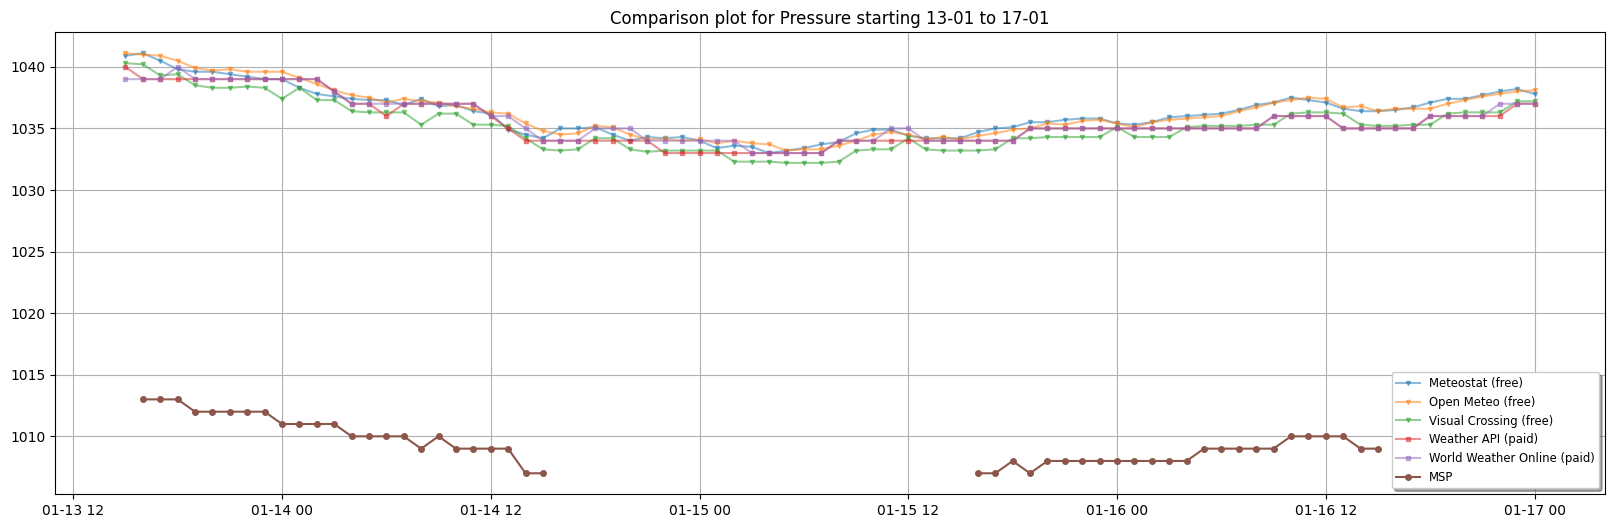


--- Analysis for Meteostat (Temperature) ---
Descriptive Statistics for Meteostat vs MSP (Temperature):
       Temperature_MSP  Temperature_Meteostat
count        95.000000              95.000000
mean          0.940000               0.431579
std           2.582033               2.685392
min          -3.800000              -5.400000
25%          -1.750000              -1.500000
50%           2.100000               1.800000
75%           3.300000               2.400000
max           4.200000               4.000000
 
MAE: 0.7547368421052629
RMSE: 1.0756148792300395
Bias: -0.508421052631579
Correlation (Temperature - MSP vs Meteostat): 0.9352927745607438
Paired t-Test (MSP vs Meteostat) for Temperature: t-stat=5.200429224772344, p-value=1.1580399862497281e-06

--- Analysis for Open Meteo (Temperature) ---
Descriptive Statistics for Open Meteo vs MSP (Temperature):
       Temperature_MSP  Temperature_Open Meteo
count        95.000000               95.000000
mean          0.940000          

In [24]:
#Weekly

#Temperature, Humidity, Pressure
plot_comparison('Pressure') 
perform_analysis_separately(cleaned_merged_data, "Temperature")

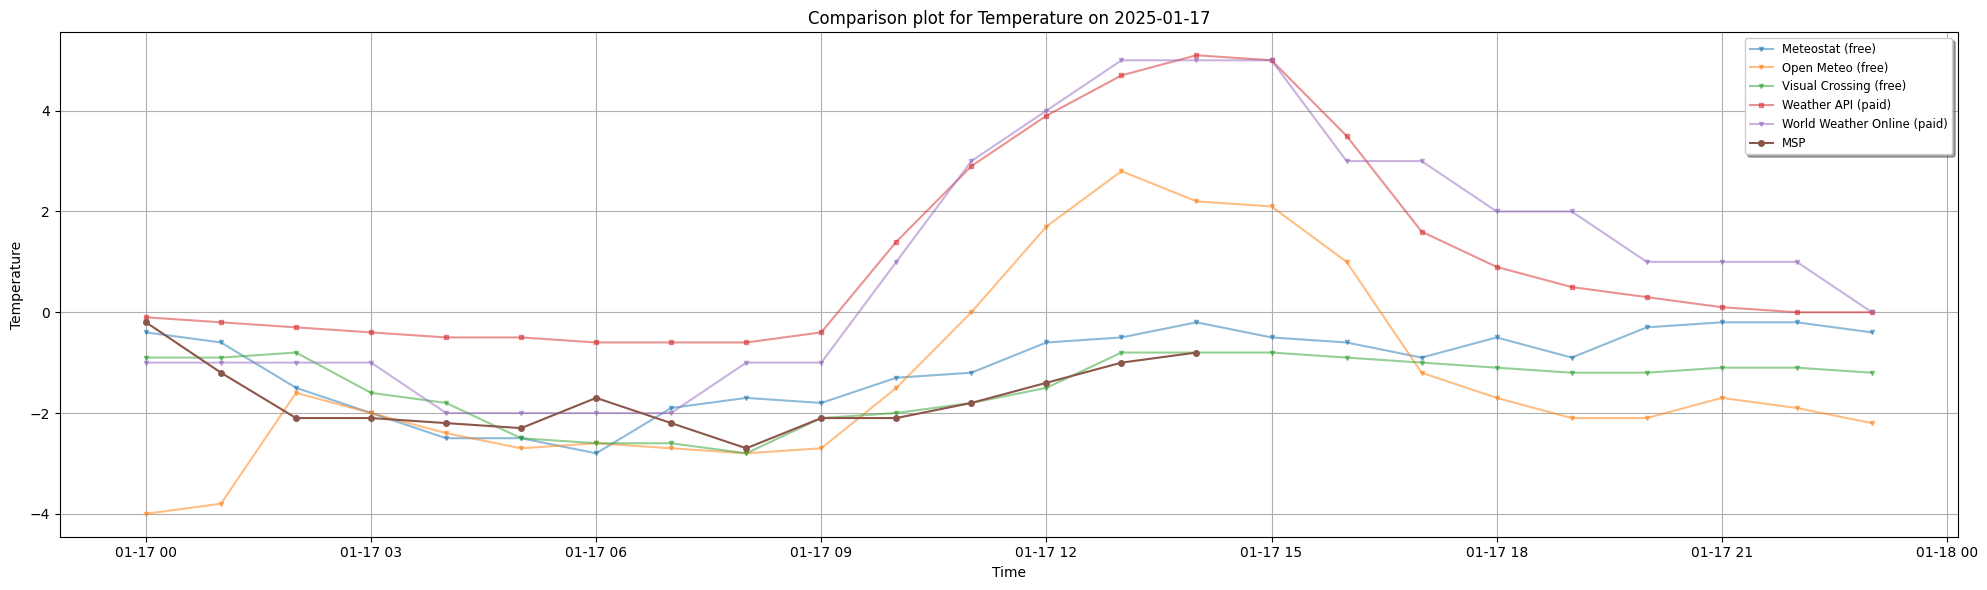

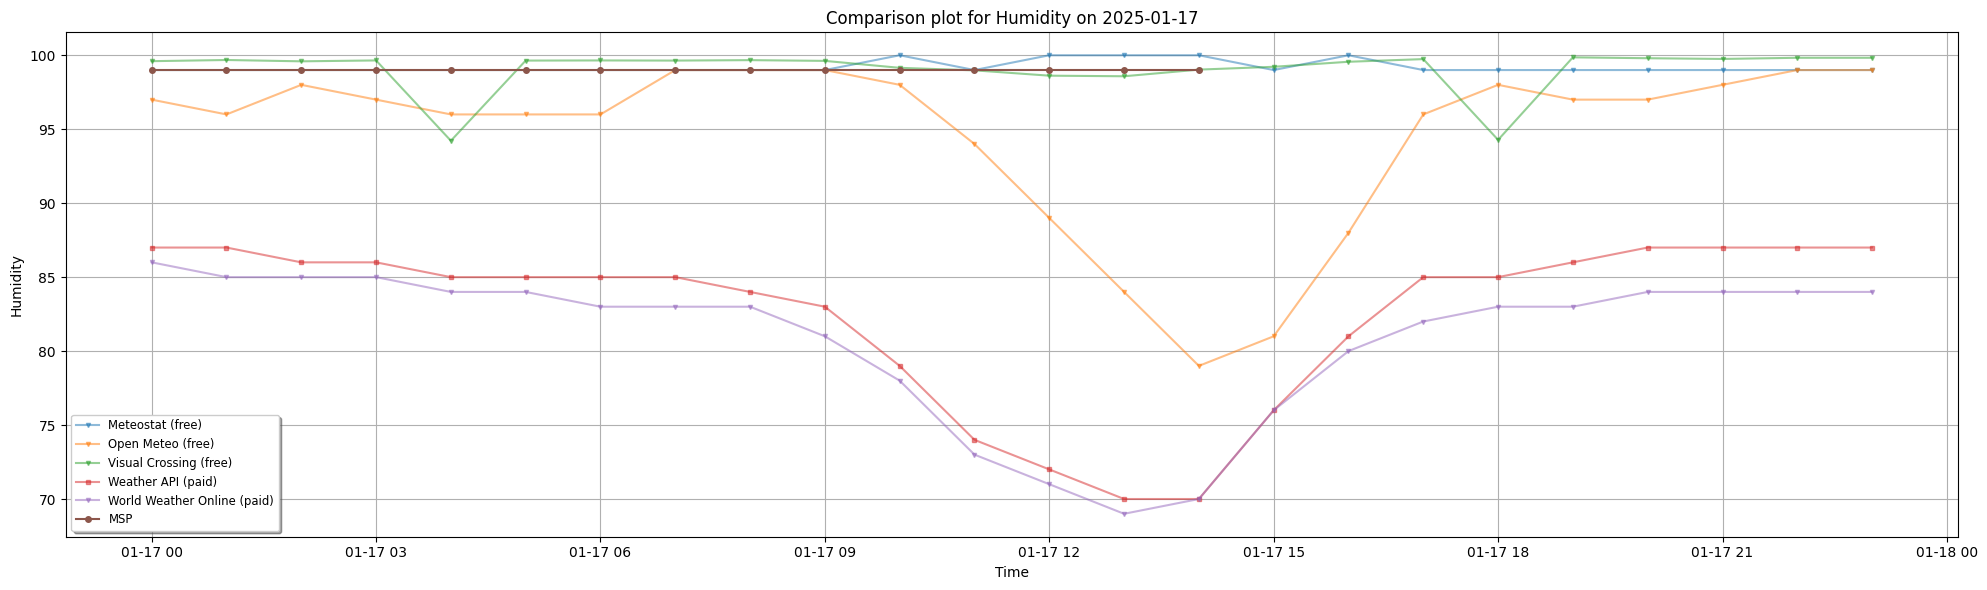

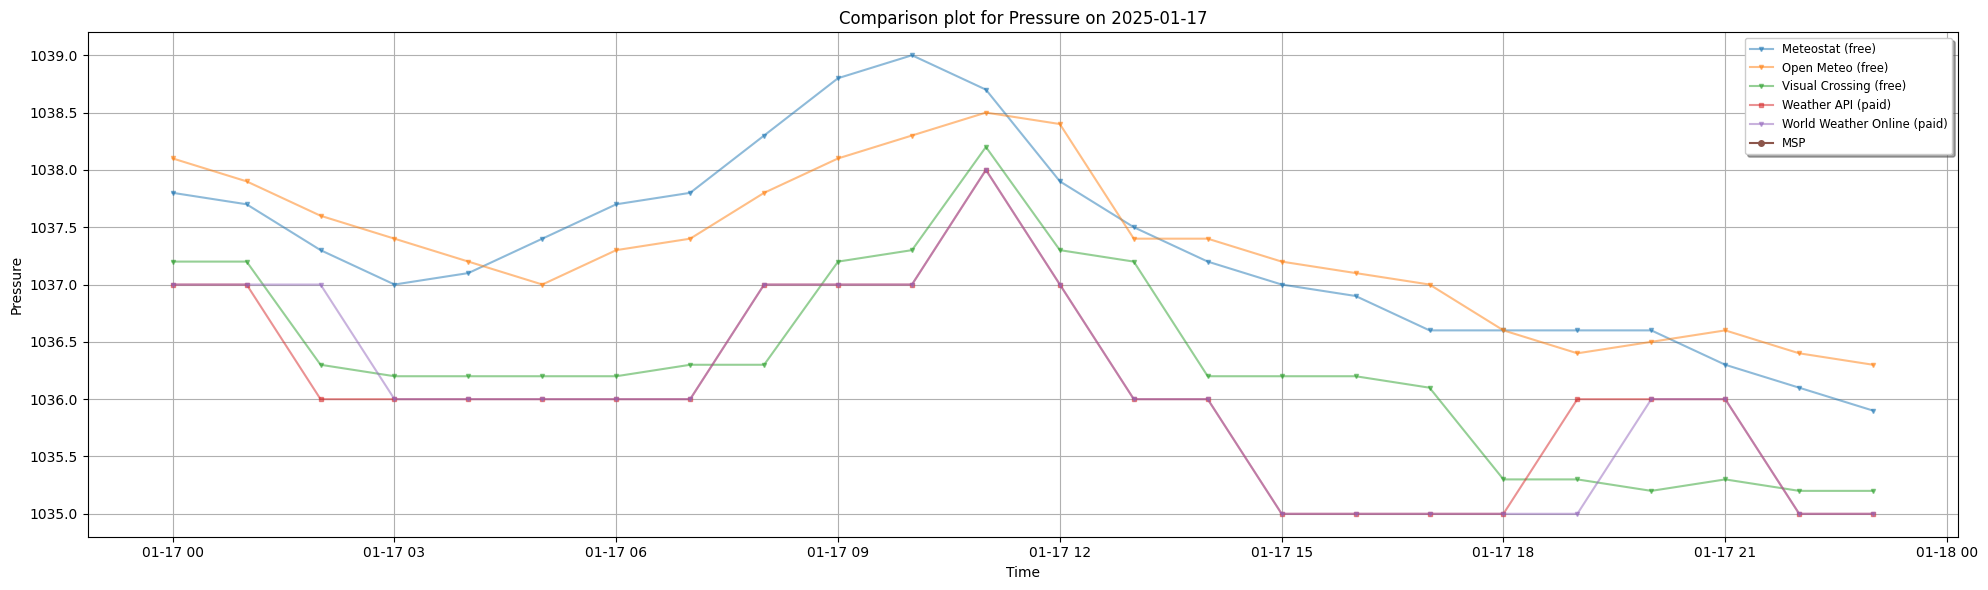

In [12]:
#Daily

#Temperature, Humidity, Pressure
#2025-01-13, 2025-01-14, 2025-01-15, 2025-01-16, 2025-01-17, 2025-01-18 (no MSP data), 2025-01-19 (no MSP data)

date = '2025-01-17'
plot_comparison_daily('Temperature', date)
plot_comparison_daily('Humidity', date)
plot_comparison_daily('Pressure', date)
#perform_analysis_daily("Temperature", cleaned_merged_data, '2025-01-16')  

**K-means clustering**

C:\Users\jelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^

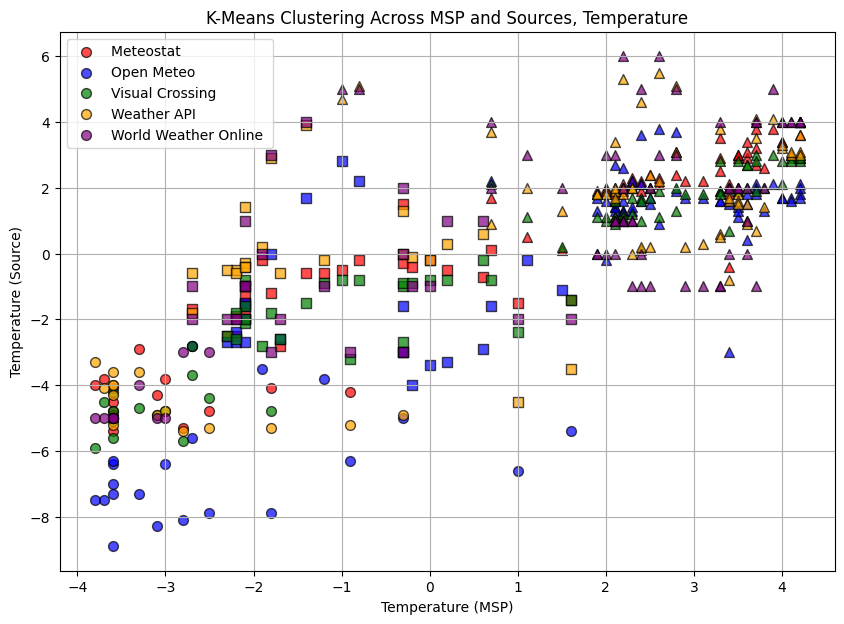

                              Temperature_MSP  Temperature
Cluster Source                                            
0       Meteostat                   -3.040000    -4.246667
        Open Meteo                  -2.338095    -6.466667
        Visual Crossing             -3.160000    -4.726667
        Weather API                 -2.880000    -4.526667
        World Weather Online        -3.350000    -4.583333
1       Meteostat                   -0.984000    -1.108000
        Open Meteo                  -0.880952    -1.552381
        Visual Crossing             -0.912000    -1.588000
        Weather API                 -1.177273    -0.163636
        World Weather Online        -1.156000    -0.720000
2       Meteostat                    2.900000     2.407273
        Open Meteo                   2.960377     1.652830
        Visual Crossing              2.900000     1.841818
        Weather API                  2.731034     2.253448
        World Weather Online         2.731034     2.1034

In [13]:
#working code 



# Combine all MSP-source data
combined_data = pd.concat([
    merged_data['Meteostat'][['Temperature_MSP', 'Temperature_Meteostat']].rename(columns={'Temperature_Meteostat': 'Temperature'}),
    merged_data['Open Meteo'][['Temperature_MSP', 'Temperature_Open Meteo']].rename(columns={'Temperature_Open Meteo': 'Temperature'}),
    merged_data['Visual Crossing'][['Temperature_MSP', 'Temperature_Visual Crossing']].rename(columns={'Temperature_Visual Crossing': 'Temperature'}),
    merged_data['Weather API'][['Temperature_MSP', 'Temperature_Weather API']].rename(columns={'Temperature_Weather API': 'Temperature'}),
    merged_data['World Weather Online'][['Temperature_MSP', 'Temperature_World Weather Online']].rename(columns={'Temperature_World Weather Online': 'Temperature'})
], keys=['Meteostat', 'Open Meteo', 'Visual Crossing', 'Weather API', 'World Weather Online']).reset_index(level=0).rename(columns={'level_0': 'Source'})


combined_data = combined_data.dropna()
scaler = StandardScaler()
normalized_data = scaler.fit_transform(combined_data[['Temperature_MSP', 'Temperature']])


optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
combined_data['Cluster'] = kmeans.fit_predict(normalized_data)


cluster_markers = ['o', 's', '^']  # circle,square,triangle


source_colors = {
    'Meteostat': 'red',
    'Open Meteo': 'blue',
    'Visual Crossing': 'green',
    'Weather API': 'orange',
    'World Weather Online': 'purple'
}

plt.figure(figsize=(10, 7))
for cluster_label in range(optimal_k):
    for source in combined_data['Source'].unique():
        subset = combined_data[(combined_data['Cluster'] == cluster_label) & (combined_data['Source'] == source)]
        plt.scatter(
            subset['Temperature_MSP'],
            subset['Temperature'],
            label=f'{source} ' if cluster_label == 0 else None,  # Avoid duplicate legends
            color=source_colors[source],
            marker=cluster_markers[cluster_label],
            s=50,
            alpha=0.7,
            edgecolors='k'
        )


plt.xlabel('Temperature (MSP)')
plt.ylabel('Temperature (Source)')
plt.title('K-Means Clustering Across MSP and Sources, Temperature')
plt.legend()
plt.grid(True)
plt.show()


print(combined_data.groupby(['Cluster', 'Source']).mean())


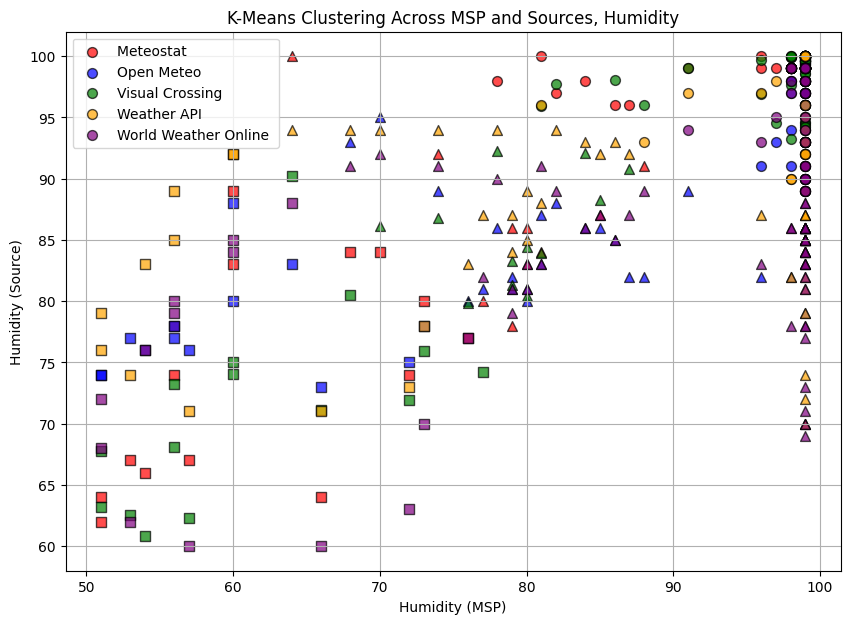

                              Humidity_MSP   Humidity
Cluster Source                                       
0       Meteostat                97.285714  99.185714
        Open Meteo               98.796610  97.033898
        Visual Crossing          97.779412  98.957794
        Weather API              97.860465  95.395349
        World Weather Online     98.454545  94.818182
1       Meteostat                61.533333  74.200000
        Open Meteo               59.461538  77.615385
        Visual Crossing          61.200000  71.411333
        Weather API              59.083333  80.250000
        World Weather Online     60.642857  73.142857
2       Meteostat                78.700000  86.700000
        Open Meteo               83.391304  84.478261
        Visual Crossing          79.416667  85.790833
        Weather API              90.075000  85.775000
        World Weather Online     92.125000  83.583333


In [ ]:
# Combine all MSP-source data for Humidity
combined_data = pd.concat([
    merged_data['Meteostat'][['Humidity_MSP', 'Humidity_Meteostat']].rename(columns={'Humidity_Meteostat': 'Humidity'}),
    merged_data['Open Meteo'][['Humidity_MSP', 'Humidity_Open Meteo']].rename(columns={'Humidity_Open Meteo': 'Humidity'}),
    merged_data['Visual Crossing'][['Humidity_MSP', 'Humidity_Visual Crossing']].rename(columns={'Humidity_Visual Crossing': 'Humidity'}),
    merged_data['Weather API'][['Humidity_MSP', 'Humidity_Weather API']].rename(columns={'Humidity_Weather API': 'Humidity'}),
    merged_data['World Weather Online'][['Humidity_MSP', 'Humidity_World Weather Online']].rename(columns={'Humidity_World Weather Online': 'Humidity'})
], keys=['Meteostat', 'Open Meteo', 'Visual Crossing', 'Weather API', 'World Weather Online']).reset_index(level=0).rename(columns={'level_0': 'Source'})


combined_data = combined_data.dropna()
scaler = StandardScaler()
normalized_data = scaler.fit_transform(combined_data[['Humidity_MSP', 'Humidity']])


optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
combined_data['Cluster'] = kmeans.fit_predict(normalized_data)


cluster_markers = ['o', 's', '^']  # circle, square, triangle


source_colors = {
    'Meteostat': 'red',
    'Open Meteo': 'blue',
    'Visual Crossing': 'green',
    'Weather API': 'orange',
    'World Weather Online': 'purple'
}

plt.figure(figsize=(10, 7))
for cluster_label in range(optimal_k):
    for source in combined_data['Source'].unique():
        subset = combined_data[(combined_data['Cluster'] == cluster_label) & (combined_data['Source'] == source)]
        plt.scatter(
            subset['Humidity_MSP'],
            subset['Humidity'],
            label=f'{source} ' if cluster_label == 0 else None,  
            color=source_colors[source],
            marker=cluster_markers[cluster_label],
            s=50,
            alpha=0.7,
            edgecolors='k'
        )


plt.xlabel('Humidity (MSP)')
plt.ylabel('Humidity (Source)')
plt.title('K-Means Clustering Across MSP and Sources, Humidity')
plt.legend()
plt.grid(True)
plt.show()


print(combined_data.groupby(['Cluster', 'Source']).mean())


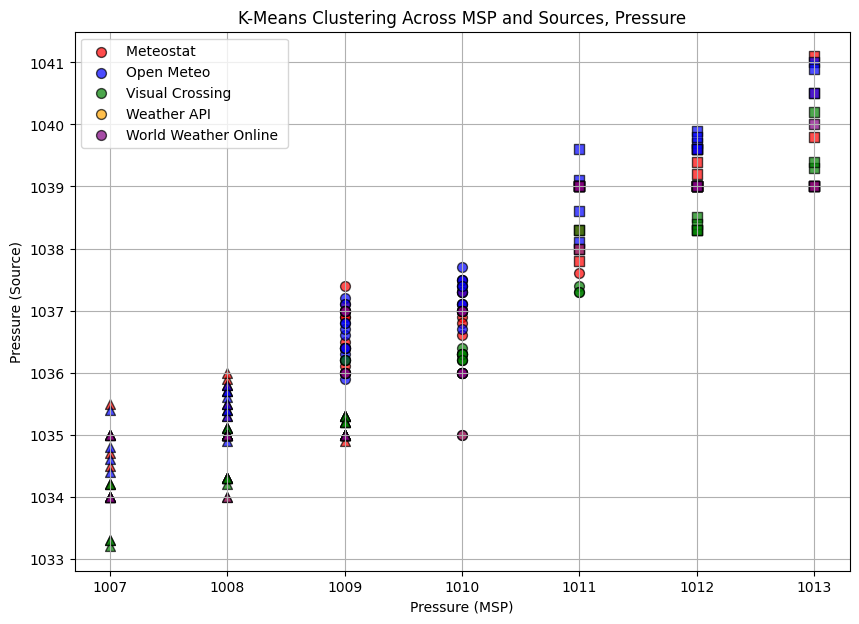

                              Pressure_MSP     Pressure
Cluster Source                                         
0       Meteostat              1009.523810  1036.871429
        Open Meteo             1009.428571  1036.861905
        Visual Crossing        1010.153846  1036.515385
        Weather API            1009.642857  1036.428571
        World Weather Online   1009.600000  1036.466667
1       Meteostat              1012.000000  1039.390909
        Open Meteo             1011.916667  1039.700000
        Visual Crossing        1012.222222  1038.777778
        Weather API            1011.916667  1038.916667
        World Weather Online   1011.916667  1039.000000
2       Meteostat              1007.750000  1035.300000
        Open Meteo             1007.666667  1035.240000
        Visual Crossing        1008.230769  1034.634615
        Weather API            1008.090909  1034.772727
        World Weather Online   1008.047619  1034.809524


In [ ]:
# Combine all MSP-source data for Pressure
combined_data = pd.concat([
    merged_data['Meteostat'][['Pressure_MSP', 'Pressure_Meteostat']].rename(columns={'Pressure_Meteostat': 'Pressure'}),
    merged_data['Open Meteo'][['Pressure_MSP', 'Pressure_Open Meteo']].rename(columns={'Pressure_Open Meteo': 'Pressure'}),
    merged_data['Visual Crossing'][['Pressure_MSP', 'Pressure_Visual Crossing']].rename(columns={'Pressure_Visual Crossing': 'Pressure'}),
    merged_data['Weather API'][['Pressure_MSP', 'Pressure_Weather API']].rename(columns={'Pressure_Weather API': 'Pressure'}),
    merged_data['World Weather Online'][['Pressure_MSP', 'Pressure_World Weather Online']].rename(columns={'Pressure_World Weather Online': 'Pressure'})
], keys=['Meteostat', 'Open Meteo', 'Visual Crossing', 'Weather API', 'World Weather Online']).reset_index(level=0).rename(columns={'level_0': 'Source'})


combined_data = combined_data.dropna()
scaler = StandardScaler()
normalized_data = scaler.fit_transform(combined_data[['Pressure_MSP', 'Pressure']])


optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
combined_data['Cluster'] = kmeans.fit_predict(normalized_data)


cluster_markers = ['o', 's', '^']  # circle, square, triangle


source_colors = {
    'Meteostat': 'red',
    'Open Meteo': 'blue',
    'Visual Crossing': 'green',
    'Weather API': 'orange',
    'World Weather Online': 'purple'
}

plt.figure(figsize=(10, 7))
for cluster_label in range(optimal_k):
    for source in combined_data['Source'].unique():
        subset = combined_data[(combined_data['Cluster'] == cluster_label) & (combined_data['Source'] == source)]
        plt.scatter(
            subset['Pressure_MSP'],
            subset['Pressure'],
            label=f'{source} ' if cluster_label == 0 else None,  
            color=source_colors[source],
            marker=cluster_markers[cluster_label],
            s=50,
            alpha=0.7,
            edgecolors='k'
        )


plt.xlabel('Pressure (MSP)')
plt.ylabel('Pressure (Source)')
plt.title('K-Means Clustering Across MSP and Sources, Pressure')
plt.legend()
plt.grid(True)
plt.show()


print(combined_data.groupby(['Cluster', 'Source']).mean())


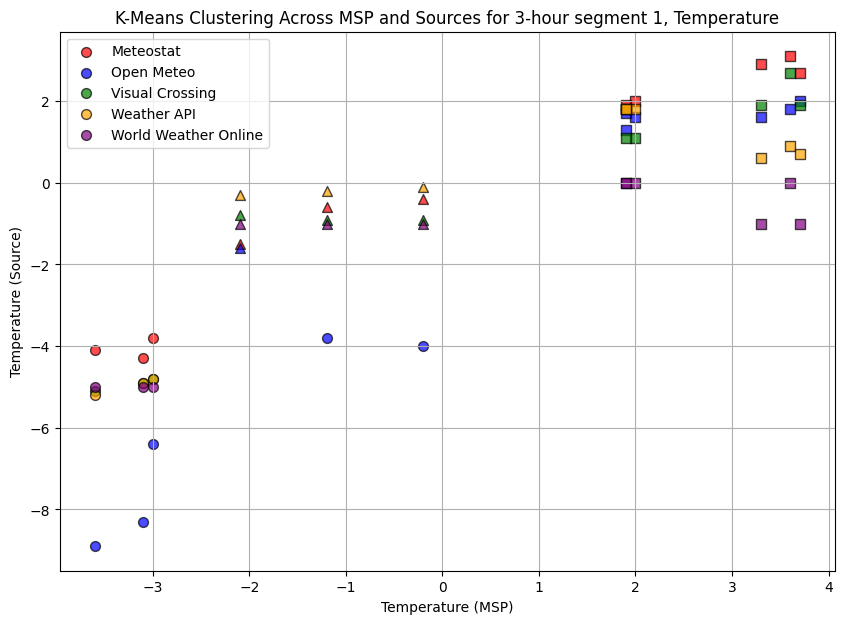

                              Temperature_MSP  Temperature
Cluster Source                                            
0       Meteostat                   -3.233333    -4.066667
        Open Meteo                  -2.220000    -6.280000
        Visual Crossing             -3.233333    -4.933333
        Weather API                 -3.233333    -4.966667
        World Weather Online        -3.233333    -5.000000
1       Meteostat                    2.733333     2.400000
        Open Meteo                   2.733333     1.666667
        Visual Crossing              2.733333     1.750000
        Weather API                  2.733333     1.266667
        World Weather Online         2.733333    -0.333333
2       Meteostat                   -1.166667    -0.833333
        Open Meteo                  -2.100000    -1.600000
        Visual Crossing             -1.166667    -0.866667
        Weather API                 -1.166667    -0.200000
        World Weather Online        -1.166667    -1.0000

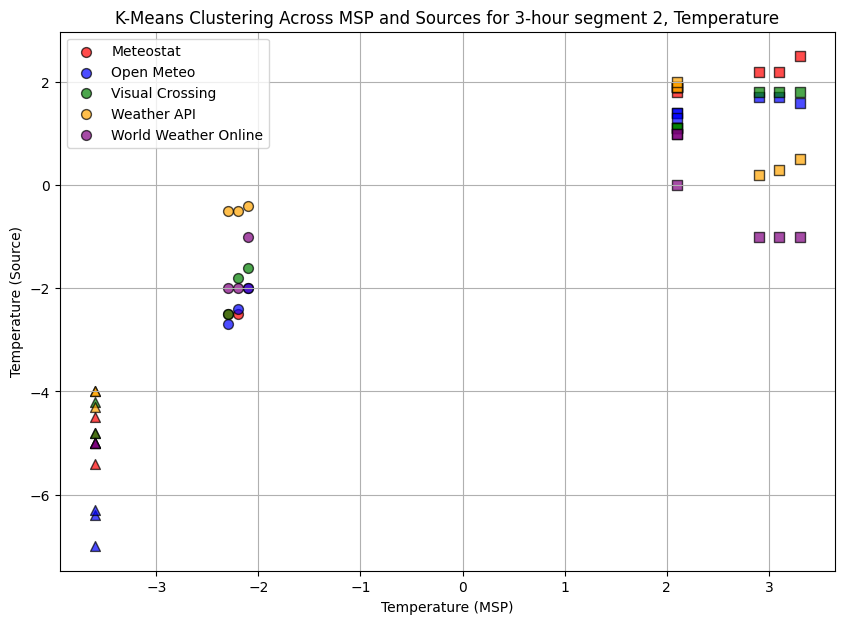

                              Temperature_MSP  Temperature
Cluster Source                                            
0       Meteostat                        -2.2    -2.333333
        Open Meteo                       -2.2    -2.366667
        Visual Crossing                  -2.2    -1.966667
        Weather API                      -2.2    -0.466667
        World Weather Online             -2.2    -1.666667
1       Meteostat                         2.6     2.083333
        Open Meteo                        2.6     1.516667
        Visual Crossing                   2.6     1.450000
        Weather API                       2.6     1.133333
        World Weather Online              2.6    -0.166667
2       Meteostat                        -3.6    -4.900000
        Open Meteo                       -3.6    -6.566667
        Visual Crossing                  -3.6    -4.666667
        Weather API                      -3.6    -4.100000
        World Weather Online             -3.6    -5.0000

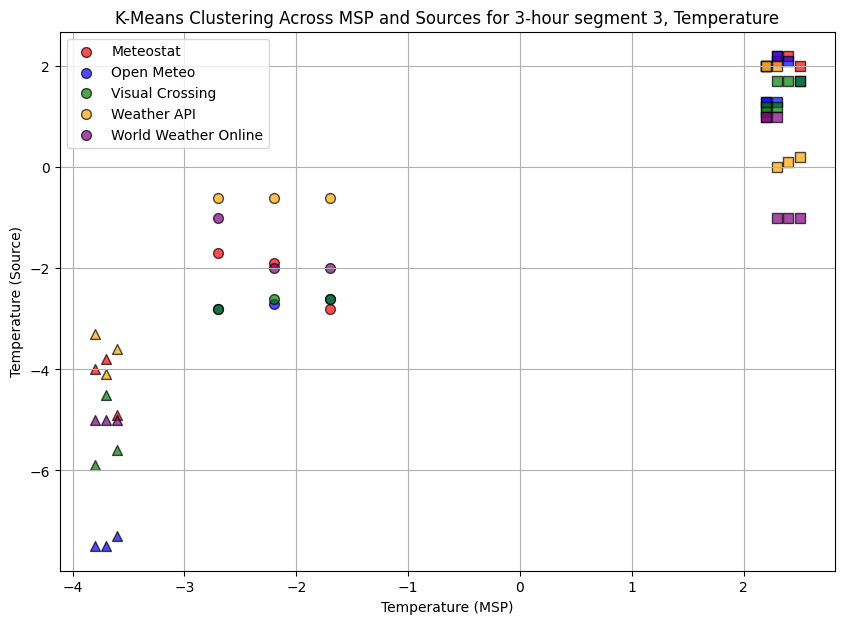

                              Temperature_MSP  Temperature
Cluster Source                                            
0       Meteostat                   -2.200000    -2.133333
        Open Meteo                  -2.200000    -2.700000
        Visual Crossing             -2.200000    -2.666667
        Weather API                 -2.200000    -0.600000
        World Weather Online        -2.200000    -1.666667
1       Meteostat                    2.316667     2.083333
        Open Meteo                   2.316667     1.650000
        Visual Crossing              2.316667     1.433333
        Weather API                  2.316667     1.050000
        World Weather Online         2.316667     0.000000
2       Meteostat                   -3.700000    -4.233333
        Open Meteo                  -3.700000    -7.433333
        Visual Crossing             -3.700000    -5.333333
        Weather API                 -3.700000    -3.666667
        World Weather Online        -3.700000    -5.0000

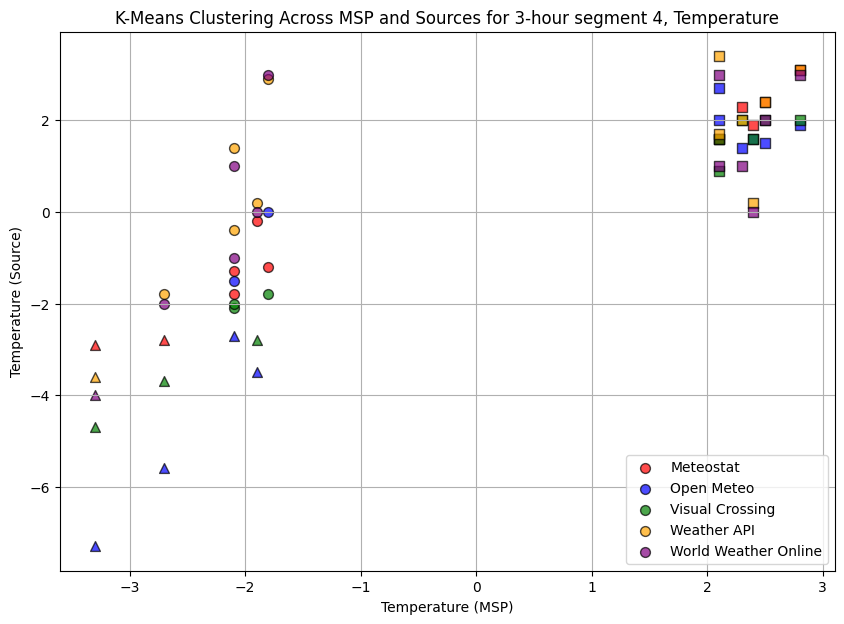

                              Temperature_MSP  Temperature
Cluster Source                                            
0       Meteostat                   -1.975000    -1.125000
        Open Meteo                  -1.950000    -0.750000
        Visual Crossing             -2.000000    -1.966667
        Weather API                 -2.120000     0.460000
        World Weather Online        -2.120000     0.200000
1       Meteostat                    2.366667     2.150000
        Open Meteo                   2.366667     1.850000
        Visual Crossing              2.366667     1.683333
        Weather API                  2.366667     2.133333
        World Weather Online         2.366667     1.666667
2       Meteostat                   -3.000000    -2.850000
        Open Meteo                  -2.500000    -4.775000
        Visual Crossing             -2.633333    -3.733333
        Weather API                 -3.300000    -3.600000
        World Weather Online        -3.300000    -4.0000

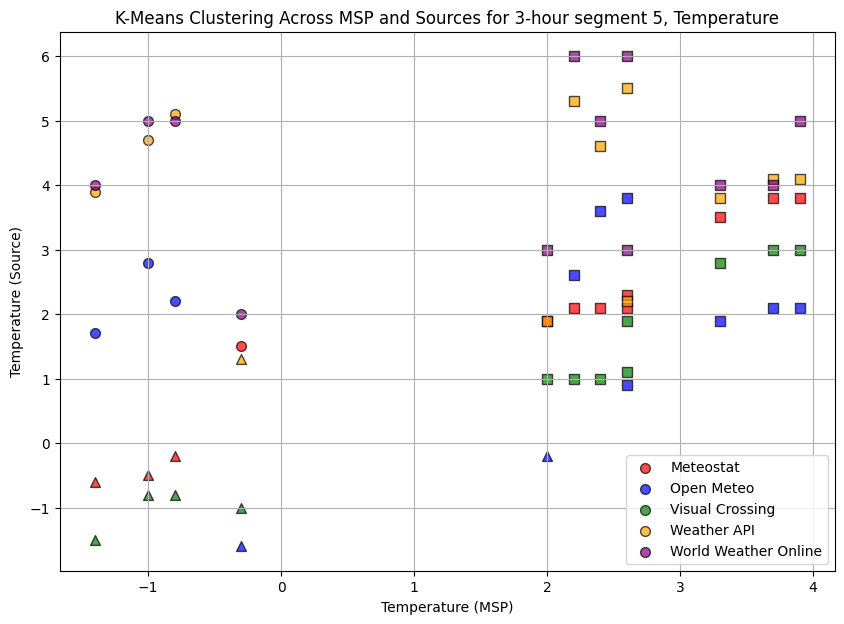

                              Temperature_MSP  Temperature
Cluster Source                                            
0       Meteostat                   -0.300000     1.500000
        Open Meteo                  -1.066667     2.233333
        Weather API                 -1.066667     4.566667
        World Weather Online        -0.875000     4.000000
1       Meteostat                    2.837500     2.700000
        Open Meteo                   2.957143     2.428571
        Visual Crossing              2.837500     1.850000
        Weather API                  2.837500     3.937500
        World Weather Online         2.837500     4.500000
2       Meteostat                   -1.066667    -0.433333
        Open Meteo                   0.850000    -0.900000
        Visual Crossing             -0.875000    -1.025000
        Weather API                 -0.300000     1.300000


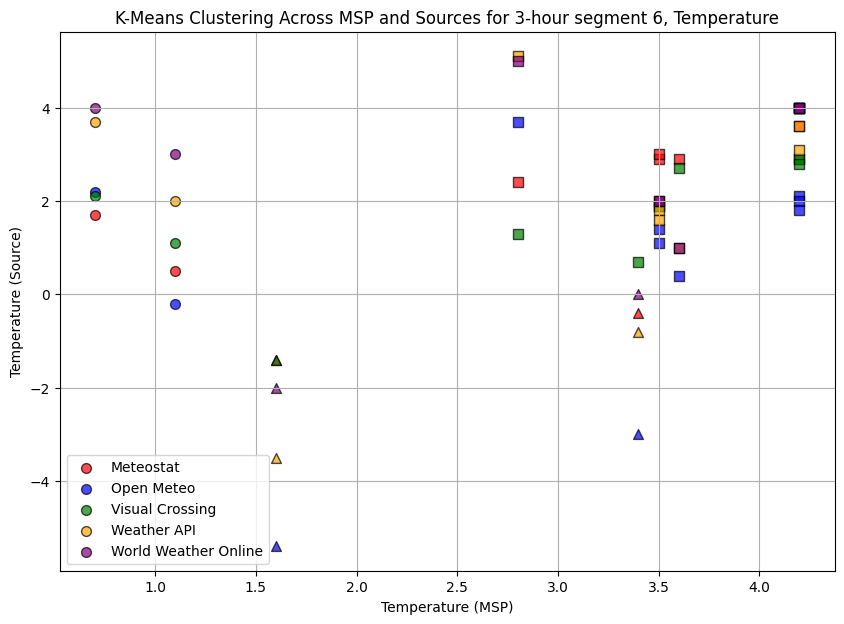

                              Temperature_MSP  Temperature
Cluster Source                                            
0       Meteostat                    0.900000     1.100000
        Open Meteo                   0.900000     1.000000
        Visual Crossing              0.900000     1.600000
        Weather API                  0.900000     2.850000
        World Weather Online         0.900000     3.500000
1       Meteostat                    3.714286     3.257143
        Open Meteo                   3.714286     1.785714
        Visual Crossing              3.675000     2.137500
        Weather API                  3.714286     2.885714
        World Weather Online         3.714286     3.142857
2       Meteostat                    2.500000    -0.900000
        Open Meteo                   2.500000    -4.200000
        Visual Crossing              1.600000    -1.400000
        Weather API                  2.500000    -2.150000
        World Weather Online         2.500000    -1.0000

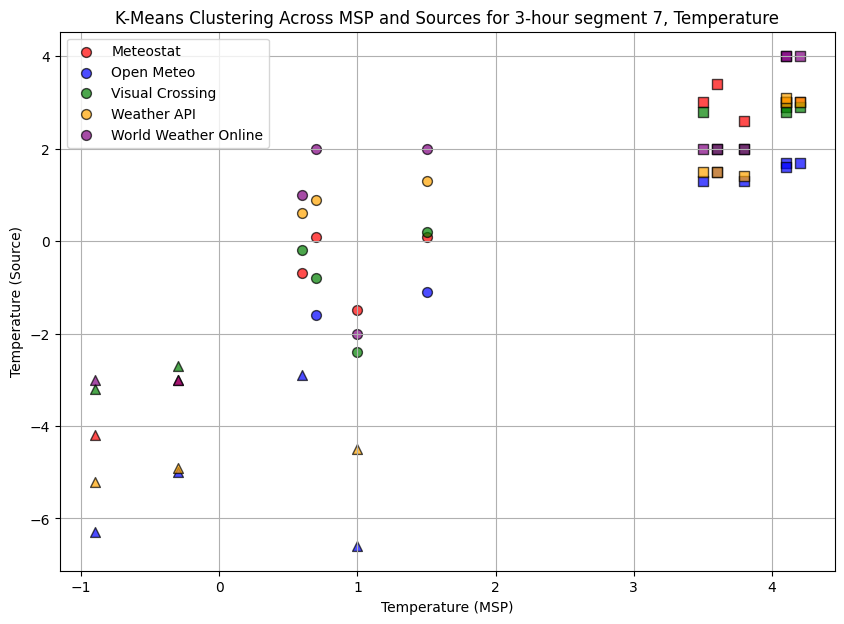

                              Temperature_MSP  Temperature
Cluster Source                                            
0       Meteostat                    0.950000    -0.500000
        Open Meteo                   1.100000    -1.350000
        Visual Crossing              0.950000    -0.800000
        Weather API                  0.933333     0.933333
        World Weather Online         0.950000     0.750000
1       Meteostat                    3.883333     3.000000
        Open Meteo                   3.883333     1.516667
        Visual Crossing              3.883333     2.566667
        Weather API                  3.883333     2.250000
        World Weather Online         3.883333     3.000000
2       Meteostat                   -0.600000    -3.600000
        Open Meteo                   0.100000    -5.200000
        Visual Crossing             -0.600000    -2.950000
        Weather API                 -0.066667    -4.866667
        World Weather Online        -0.600000    -3.0000

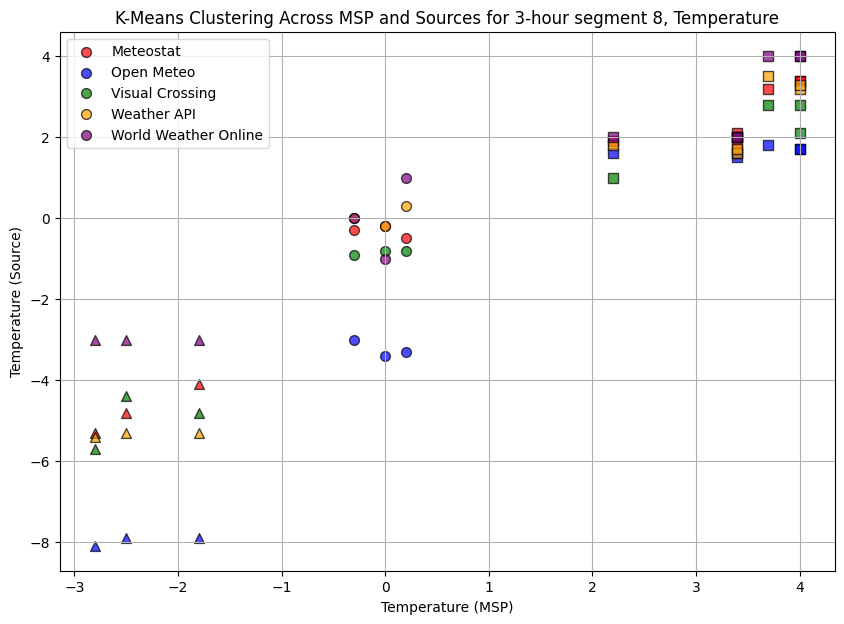

                              Temperature_MSP  Temperature
Cluster Source                                            
0       Meteostat                   -0.033333    -0.333333
        Open Meteo                  -0.033333    -3.233333
        Visual Crossing             -0.033333    -0.833333
        Weather API                 -0.033333     0.033333
        World Weather Online        -0.033333     0.000000
1       Meteostat                    3.450000     2.633333
        Open Meteo                   3.450000     1.650000
        Visual Crossing              3.450000     2.116667
        Weather API                  3.450000     2.516667
        World Weather Online         3.450000     3.000000
2       Meteostat                   -2.366667    -4.733333
        Open Meteo                  -2.366667    -7.966667
        Visual Crossing             -2.366667    -4.966667
        Weather API                 -2.366667    -5.333333
        World Weather Online        -2.366667    -3.0000

In [ ]:
for segment_choice in range(1, 9):
    filtered_data = {
        'Meteostat': merged_data['Meteostat'][merged_data['Meteostat']['hour segment_MSP'] == segment_choice][['Temperature_MSP', 'Temperature_Meteostat']].rename(columns={'Temperature_Meteostat': 'Temperature'}),
        'Open Meteo': merged_data['Open Meteo'][merged_data['Open Meteo']['hour segment_MSP'] == segment_choice][['Temperature_MSP', 'Temperature_Open Meteo']].rename(columns={'Temperature_Open Meteo': 'Temperature'}),
        'Visual Crossing': merged_data['Visual Crossing'][merged_data['Visual Crossing']['hour segment_MSP'] == segment_choice][['Temperature_MSP', 'Temperature_Visual Crossing']].rename(columns={'Temperature_Visual Crossing': 'Temperature'}),
        'Weather API': merged_data['Weather API'][merged_data['Weather API']['hour segment_MSP'] == segment_choice][['Temperature_MSP', 'Temperature_Weather API']].rename(columns={'Temperature_Weather API': 'Temperature'}),
        'World Weather Online': merged_data['World Weather Online'][merged_data['World Weather Online']['hour segment_MSP'] == segment_choice][['Temperature_MSP', 'Temperature_World Weather Online']].rename(columns={'Temperature_World Weather Online': 'Temperature'})
    }

   
    combined_data = pd.concat([
        filtered_data['Meteostat'],
        filtered_data['Open Meteo'],
        filtered_data['Visual Crossing'],
        filtered_data['Weather API'],
        filtered_data['World Weather Online']
    ], keys=['Meteostat', 'Open Meteo', 'Visual Crossing', 'Weather API', 'World Weather Online']).reset_index(level=0).rename(columns={'level_0': 'Source'})

    combined_data = combined_data.dropna()
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(combined_data[['Temperature_MSP', 'Temperature']])
    optimal_k = 3  
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    combined_data['Cluster'] = kmeans.fit_predict(normalized_data)
    cluster_markers = ['o', 's', '^'] 

  
    source_colors = {
        'Meteostat': 'red',
        'Open Meteo': 'blue',
        'Visual Crossing': 'green',
        'Weather API': 'orange',
        'World Weather Online': 'purple'
    }


    plt.figure(figsize=(10, 7))
    for cluster_label in range(optimal_k):
        for source in combined_data['Source'].unique():
            subset = combined_data[(combined_data['Cluster'] == cluster_label) & (combined_data['Source'] == source)]
            plt.scatter(
                subset['Temperature_MSP'],
                subset['Temperature'],
                label=f'{source}' if cluster_label == 0 else None, 
                color=source_colors[source],
                marker=cluster_markers[cluster_label],
                s=50,
                alpha=0.7,
                edgecolors='k'
            )

    plt.xlabel('Temperature (MSP)')
    plt.ylabel('Temperature (Source)')
    plt.title(f'K-Means Clustering Across MSP and Sources for 3-hour segment {segment_choice}, Temperature') 
    plt.legend()
    plt.grid(True)
    plt.show()

    print(combined_data.groupby(['Cluster', 'Source']).mean())


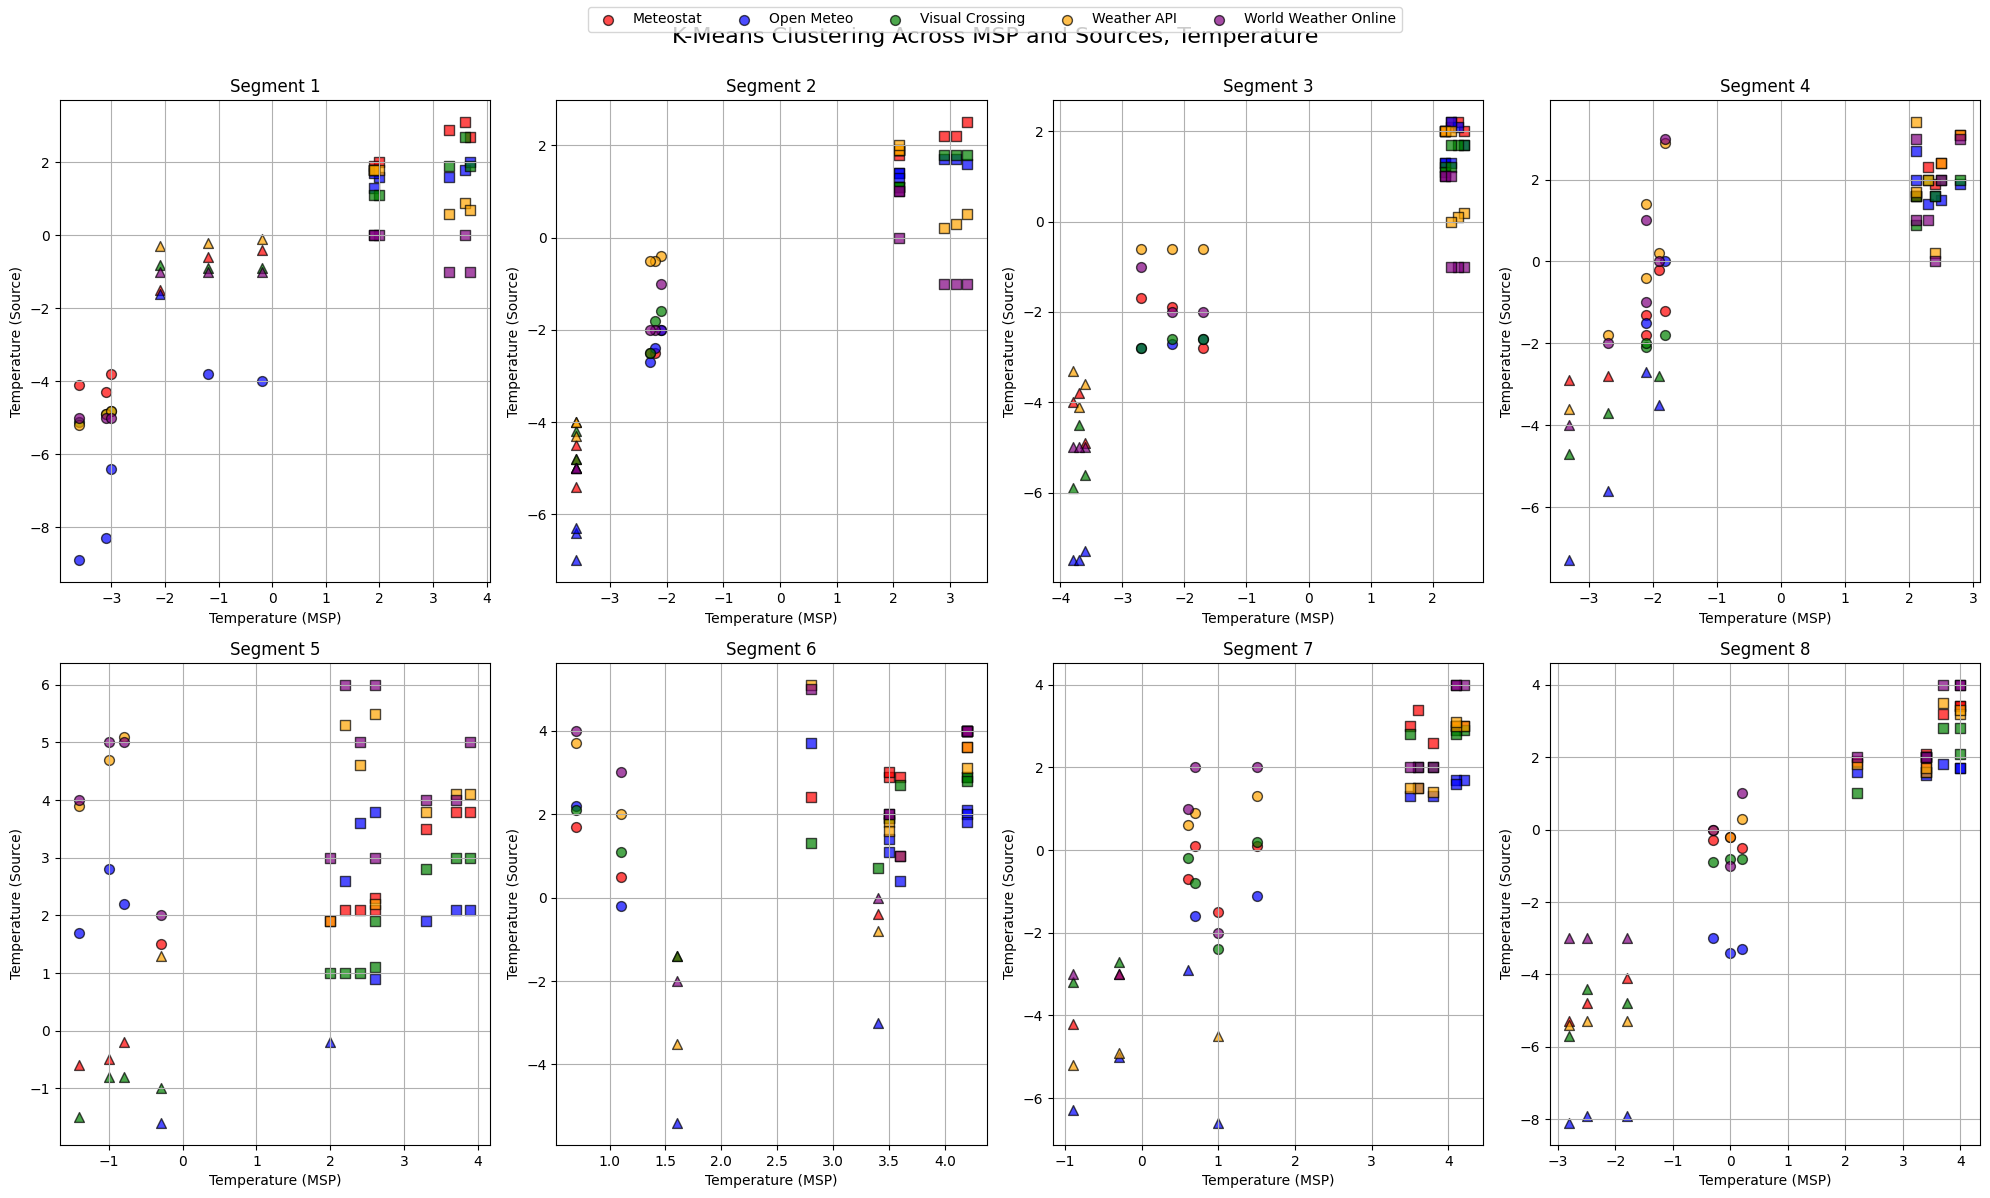

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(20, 12)) 
axes = axes.flatten()

for idx, segment_choice in enumerate(range(1, 9)):
    filtered_data = {
        'Meteostat': merged_data['Meteostat'][merged_data['Meteostat']['hour segment_MSP'] == segment_choice][['Temperature_MSP', 'Temperature_Meteostat']].rename(columns={'Temperature_Meteostat': 'Temperature'}),
        'Open Meteo': merged_data['Open Meteo'][merged_data['Open Meteo']['hour segment_MSP'] == segment_choice][['Temperature_MSP', 'Temperature_Open Meteo']].rename(columns={'Temperature_Open Meteo': 'Temperature'}),
        'Visual Crossing': merged_data['Visual Crossing'][merged_data['Visual Crossing']['hour segment_MSP'] == segment_choice][['Temperature_MSP', 'Temperature_Visual Crossing']].rename(columns={'Temperature_Visual Crossing': 'Temperature'}),
        'Weather API': merged_data['Weather API'][merged_data['Weather API']['hour segment_MSP'] == segment_choice][['Temperature_MSP', 'Temperature_Weather API']].rename(columns={'Temperature_Weather API': 'Temperature'}),
        'World Weather Online': merged_data['World Weather Online'][merged_data['World Weather Online']['hour segment_MSP'] == segment_choice][['Temperature_MSP', 'Temperature_World Weather Online']].rename(columns={'Temperature_World Weather Online': 'Temperature'})
    }

    combined_data = pd.concat([
        filtered_data['Meteostat'],
        filtered_data['Open Meteo'],
        filtered_data['Visual Crossing'],
        filtered_data['Weather API'],
        filtered_data['World Weather Online']
    ], keys=['Meteostat', 'Open Meteo', 'Visual Crossing', 'Weather API', 'World Weather Online']).reset_index(level=0).rename(columns={'level_0': 'Source'})

  
    combined_data = combined_data.dropna()
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(combined_data[['Temperature_MSP', 'Temperature']])
    optimal_k = 3  
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    combined_data['Cluster'] = kmeans.fit_predict(normalized_data)

   
    cluster_markers = ['o', 's', '^']  #circle, square, triangle

    source_colors = {
        'Meteostat': 'red',
        'Open Meteo': 'blue',
        'Visual Crossing': 'green',
        'Weather API': 'orange',
        'World Weather Online': 'purple'
    }

   
    ax = axes[idx]
    for cluster_label in range(optimal_k):
        for source in combined_data['Source'].unique():
            subset = combined_data[(combined_data['Cluster'] == cluster_label) & (combined_data['Source'] == source)]
            ax.scatter(
                subset['Temperature_MSP'],
                subset['Temperature'],
                label=f'{source}' if cluster_label == 0 else None, 
                color=source_colors[source],
                marker=cluster_markers[cluster_label],
                s=50,
                alpha=0.7,
                edgecolors='k'
            )

    ax.set_xlabel('Temperature (MSP)')
    ax.set_ylabel('Temperature (Source)')
    ax.set_title(f'Segment {segment_choice}')
    ax.grid(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, fontsize='medium')
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('K-Means Clustering Across MSP and Sources, Temperature', fontsize=16)
plt.show()


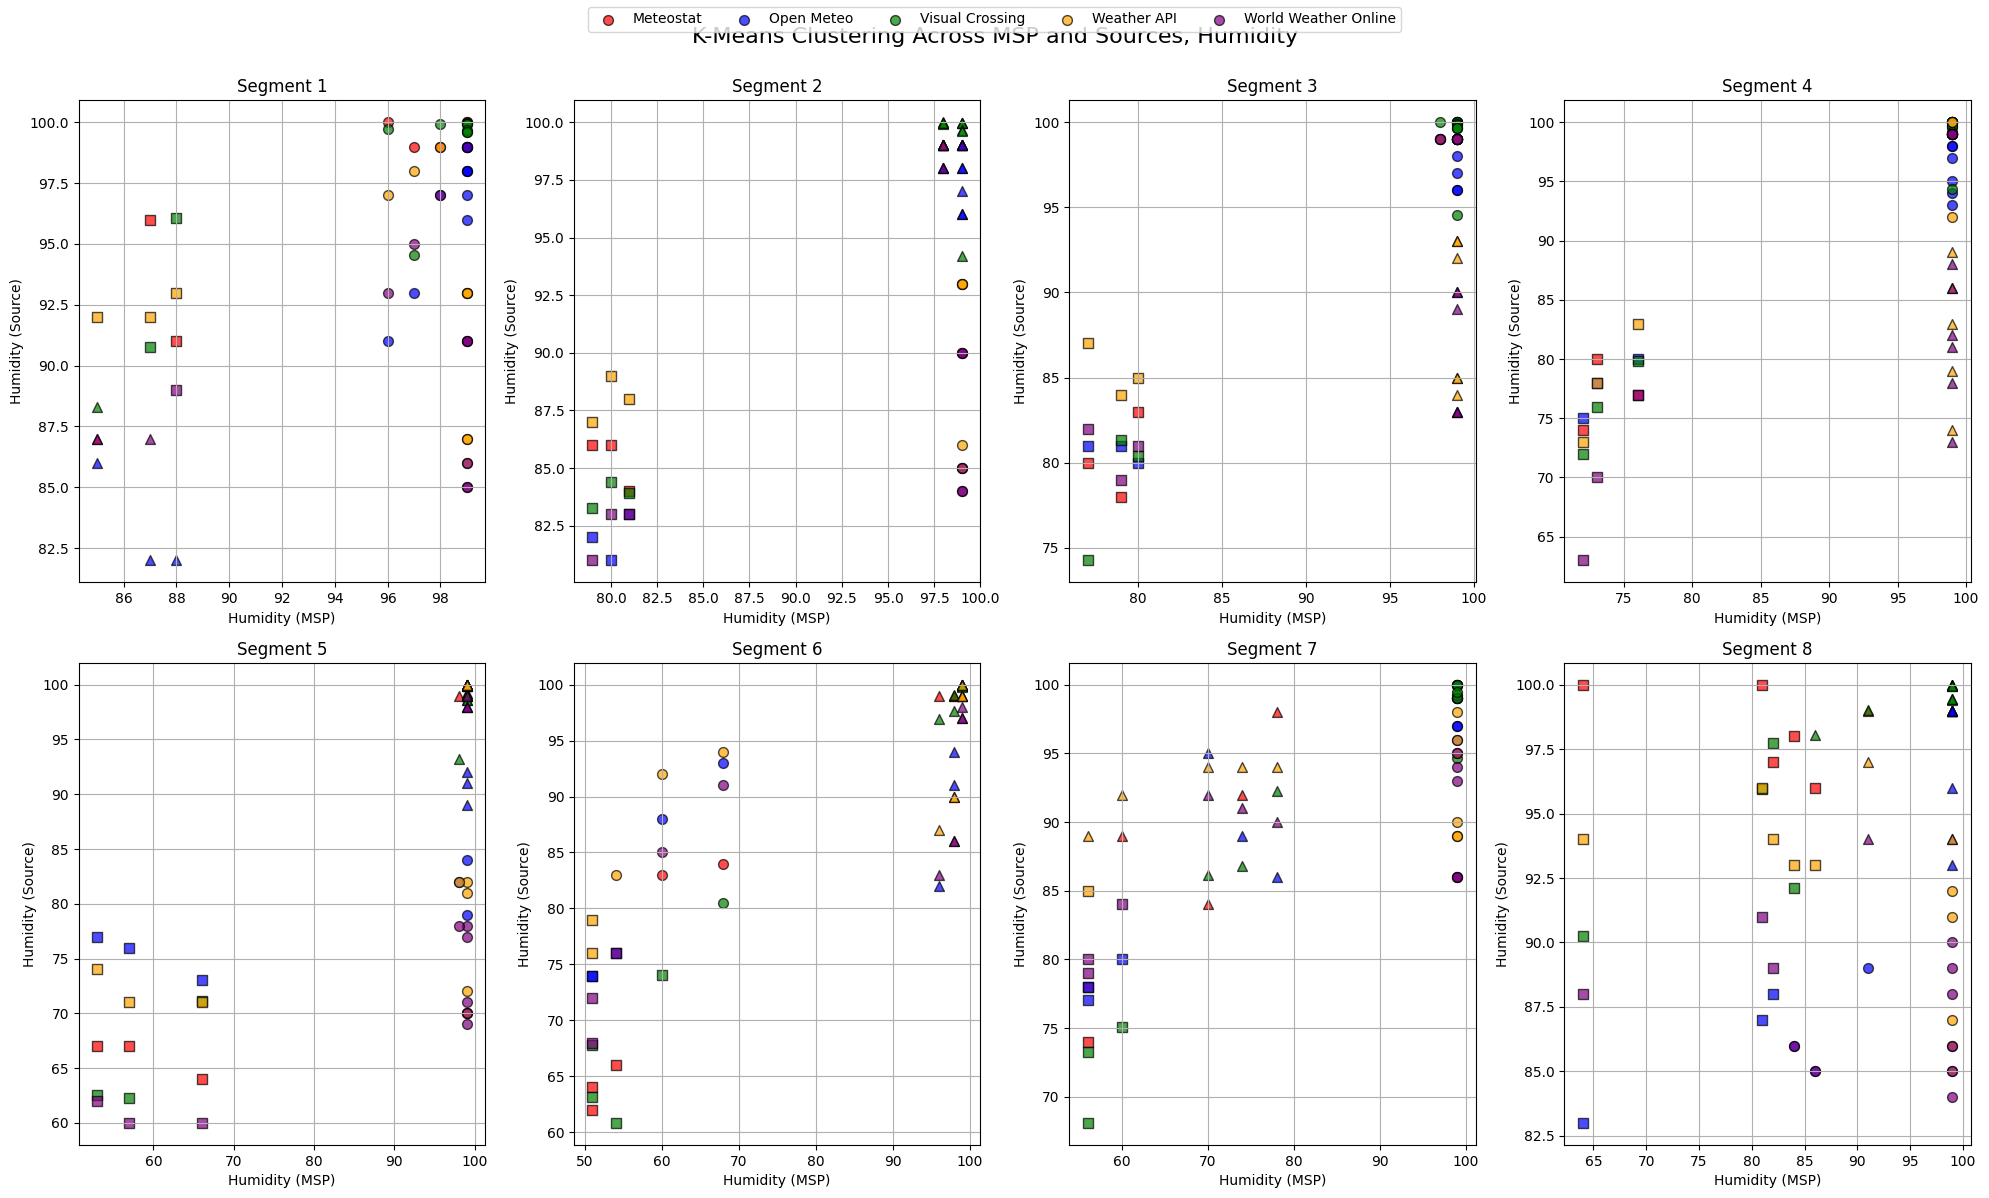

In [22]:
fig, axes = plt.subplots(2, 4, figsize=(20, 12)) 
axes = axes.flatten()

for idx, segment_choice in enumerate(range(1, 9)):
    filtered_data = {
        'Meteostat': merged_data['Meteostat'][merged_data['Meteostat']['hour segment_MSP'] == segment_choice][['Humidity_MSP', 'Humidity_Meteostat']].rename(columns={'Humidity_Meteostat': 'Humidity'}),
        'Open Meteo': merged_data['Open Meteo'][merged_data['Open Meteo']['hour segment_MSP'] == segment_choice][['Humidity_MSP', 'Humidity_Open Meteo']].rename(columns={'Humidity_Open Meteo': 'Humidity'}),
        'Visual Crossing': merged_data['Visual Crossing'][merged_data['Visual Crossing']['hour segment_MSP'] == segment_choice][['Humidity_MSP', 'Humidity_Visual Crossing']].rename(columns={'Humidity_Visual Crossing': 'Humidity'}),
        'Weather API': merged_data['Weather API'][merged_data['Weather API']['hour segment_MSP'] == segment_choice][['Humidity_MSP', 'Humidity_Weather API']].rename(columns={'Humidity_Weather API': 'Humidity'}),
        'World Weather Online': merged_data['World Weather Online'][merged_data['World Weather Online']['hour segment_MSP'] == segment_choice][['Humidity_MSP', 'Humidity_World Weather Online']].rename(columns={'Humidity_World Weather Online': 'Humidity'})
    }

    combined_data = pd.concat([
        filtered_data['Meteostat'],
        filtered_data['Open Meteo'],
        filtered_data['Visual Crossing'],
        filtered_data['Weather API'],
        filtered_data['World Weather Online']
    ], keys=['Meteostat', 'Open Meteo', 'Visual Crossing', 'Weather API', 'World Weather Online']).reset_index(level=0).rename(columns={'level_0': 'Source'})

  
    combined_data = combined_data.dropna()
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(combined_data[['Humidity_MSP', 'Humidity']])
    optimal_k = 3  
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    combined_data['Cluster'] = kmeans.fit_predict(normalized_data)

   
    cluster_markers = ['o', 's', '^']  #circle, square, triangle

    source_colors = {
        'Meteostat': 'red',
        'Open Meteo': 'blue',
        'Visual Crossing': 'green',
        'Weather API': 'orange',
        'World Weather Online': 'purple'
    }

   
    ax = axes[idx]
    for cluster_label in range(optimal_k):
        for source in combined_data['Source'].unique():
            subset = combined_data[(combined_data['Cluster'] == cluster_label) & (combined_data['Source'] == source)]
            ax.scatter(
                subset['Humidity_MSP'],
                subset['Humidity'],
                label=f'{source}' if cluster_label == 0 else None, 
                color=source_colors[source],
                marker=cluster_markers[cluster_label],
                s=50,
                alpha=0.7,
                edgecolors='k'
            )

    ax.set_xlabel('Humidity (MSP)')
    ax.set_ylabel('Humidity (Source)')
    ax.set_title(f'Segment {segment_choice}')
    ax.grid(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, fontsize='medium')
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('K-Means Clustering Across MSP and Sources, Humidity', fontsize=16)
plt.show()
